In [1]:
pip install tidytext textblob

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 12.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 KB 4.5 MB/s eta 0:00:00
  Created wheel for tidytext: filename=tidytext-0.0.1-py3-none-any.whl size=3895 sha256=4d3f7999a10a368466d4a8418971de6bb383ea059649979dc10e34b187317b74
  Stored in directory: /home/ec2-user/.cache/pip/wheels/07/03/c0/f73eeef462dd66dbca0288a338fcbcdc78e3588937ccc907d8
Successfully built tidytext
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm

from Help_Funs import count_chars, count_words, count_capital_chars, count_capital_words, count_sent, count_unique_words, count_stopwords, count_hashtags 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Covid-tweets/training_data.csv'
file_key_2 = 'Covid-tweets/test_data.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)

## Feature Engineering 
train['is_quote'] = train['is_quote'].str.lower()
train['is_quote'] = np.where(train['is_quote'] == 'false', 0, 1)
train['is_retweet'] = train['is_retweet'].str.lower()
train['is_retweet'] = np.where(train['is_retweet'] == 'false', 0, 1)
train['Trump_flag'] = np.where(train['reply_to_screen_name'] == 'realDonaldTrump', 1, 0)
train['jfrketich_flag'] = np.where(train['reply_to_screen_name'] == 'jfrketich', 1, 0)


test['is_quote'] = np.where(test['is_quote'] == False, 0, 1)
test['is_retweet'] = np.where(test['is_retweet'] == False, 0, 1)
test['Trump_flag'] = np.where(test['reply_to_screen_name'] == 'realDonaldTrump', 1, 0)
test['jfrketich_flag'] = np.where(test['reply_to_screen_name'] == 'jfrketich', 1, 0)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
## Defining stopwords
stop_words = set(stopwords.words('english'))
others = set(["1", "2", "it'll", "ill", "=", '+', "'s'", '"'])
stop_words = stop_words.union(others)

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stop_words]
    temp = " ".join(word for word in temp)
    return temp

In [5]:
train['clean_tweet'] = np.nan

for i in tqdm(range(0, test.shape[0])):
    
    train['clean_tweet'][i] =  clean_tweet(train['text'][i])

  0%|          | 0/240000 [00:00<?, ?it/s]/tmp/ipykernel_11002/4248643825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['clean_tweet'][i] =  clean_tweet(train['text'][i])
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 240000/240000 [00:09<00:00, 24610.87it/s]


In [19]:
test['clean_tweet'] = np.nan

for i in tqdm(range(0, test.shape[0])):
    
    test['clean_tweet'][i] =  clean_tweet(test['text'][i])

  0%|          | 0/60000 [00:00<?, ?it/s]/tmp/ipykernel_11002/1846826793.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['clean_tweet'][i] =  clean_tweet(test['text'][i])
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 60000/60000 [00:02<00:00, 22936.13it/s]


In [20]:
train['sentiment'] = train['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['subjectivity'] = train['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

test['sentiment'] = test['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['subjectivity'] = test['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [21]:
train['sentiment_label'] = np.where(train['sentiment'] < 0, 'negative', 
                                    np.where(train['sentiment'] == 0, 'neutral', 'positive'))

test['sentiment_label'] = np.where(test['sentiment'] < 0, 'negative', 
                                   np.where(test['sentiment'] == 0, 'neutral', 'positive'))

In [22]:
train.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,country,Trump_flag,jfrketich_flag,clean_tweet,sentiment,subjectivity,sentiment_label
0,Remember the #WuhanCoronaVirus? The pandemic w...,NaN,1,1,WuhanCoronaVirus KillerCuomo,us,0,0,remember pandemic great percentage deaths resu...,0.20000,0.250,positive
1,My sources @WhiteHouse say 2 tactics will be u...,NaN,1,1,Trump,us,0,0,sources say tactics used get america open amp ...,0.00000,0.500,neutral
2,I'll venture a wild guess: If you were running...,NaN,1,1,COVID19,us,0,0,venture wild guess running usa crisis youd wan...,0.22500,0.475,positive
3,#Pakistan (#GreenStimulus = #Nature protection...,NaN,1,1,Pakistan GreenStimulus Nature Green,us,0,0,protection jobs community youth within recentl...,0.03125,0.375,positive
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...,NaN,1,1,coronavirus COVID__19 COVIDー19,us,0,0,pand mie de 30 pasteurs ricains qui avaient mi...,0.00000,0.125,neutral


In [23]:
pd.crosstab(train['country'], train['sentiment_label'])

sentiment_label,negative,neutral,positive
country,,,
australia,7801,13675,18524
canada,7105,14325,18570
ireland,7094,13335,19571
new_zealand,7955,12669,19376
uk,7458,13753,18789
us,8604,14221,17175


In [24]:
train.groupby('country')['subjectivity'].mean()

country
australia      0.349610
canada         0.341311
ireland        0.356503
new_zealand    0.360390
uk             0.350597
us             0.339600
Name: subjectivity, dtype: float64

In [26]:
test.head()

,text,reply_to_screen_name,is_quote,is_retweet,hashtags,Id,Trump_flag,jfrketich_flag,clean_tweet,sentiment,subjectivity,sentiment_label
0,"Ethical investing is not optional anymore, say...",NaN,0,0,covid19,0,0,0,ethical investing optional anymore says sris j...,0.150000,0.550,positive
1,#COVID19 | Suite à la conférence de presse du ...,NaN,0,1,COVID19,1,0,0,suite la conf rence de presse du premier minis...,0.000000,0.000,neutral
2,"Yesterday, I had a live discussion with @Steve...",NaN,0,1,COVID19,2,0,0,yesterday live discussion assured us scientist...,0.412121,0.600,positive
3,Nepal - #Coronavirus cases up 24% in a week. D...,NaN,0,1,Coronavirus,3,0,0,nepal cases 24 week deaths 31 totals 53 120 ca...,0.000000,0.000,neutral
4,American economy jumped up a % big news story...,NaN,0,0,LysolAndCloroxSales,4,0,0,american economy jumped big news story whole d...,0.000000,0.325,neutral


In [27]:
train.to_csv('train_new_1.csv', index = False)
test.to_csv('test_new_1.csv', index = False)

In [25]:
pd.get_dummies(train['sentiment_label'])

,negative,neutral,positive
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,1,0
...,...,...,...
239995,0,1,0
239996,0,0,1
239997,0,0,1
239998,1,0,0


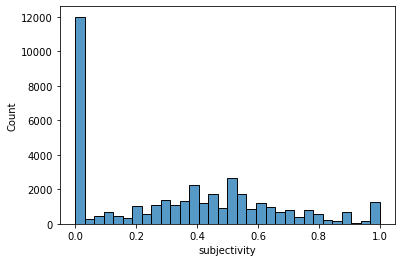

In [13]:
sns.histplot(x = 'subjectivity', data = train[train['country'] == 'us'])
plt.show()

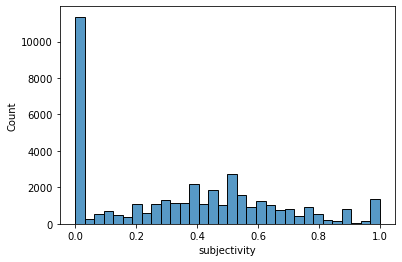

In [14]:
sns.histplot(x = 'subjectivity', data = train[train['country'] == 'uk'])
plt.show()

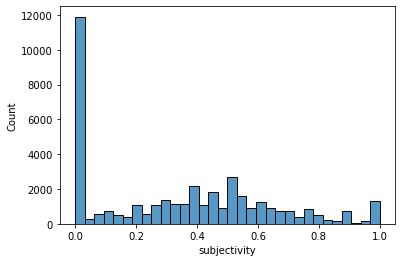

In [15]:
sns.histplot(x = 'subjectivity', data = train[train['country'] == 'canada'])
plt.show()

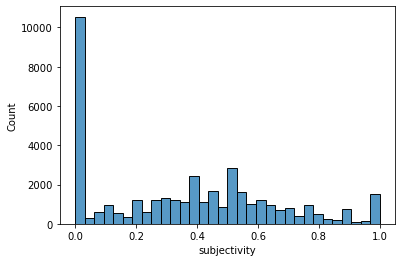

In [16]:
sns.histplot(x = 'subjectivity', data = train[train['country'] == 'ireland'])
plt.show()

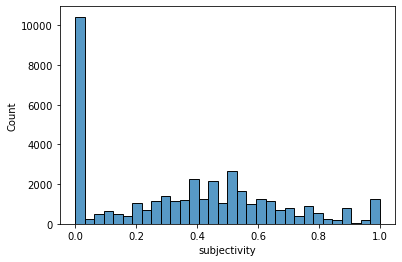

In [17]:
sns.histplot(x = 'subjectivity', data = train[train['country'] == 'new_zealand'])
plt.show()

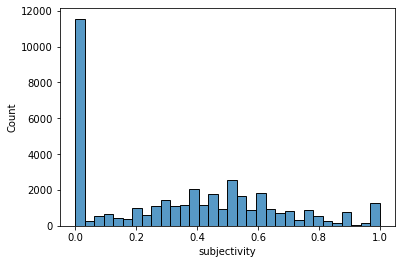

In [18]:
sns.histplot(x = 'subjectivity', data = train[train['country'] == 'australia'])
plt.show()